# ResNet18 and VGG16-BN Hybrid

This notebook explores a hybrid model combining a pre-trained VGG16-BN backbone with a pre-trained ResNet18 backbone, initialised with ImageNet weights. This combines the strengths of VGG16’s ability to capture complex patterns and ResNet18’s efficiency and ability to build deeper networks with residual connections. 

The model runs both pre-trained backbones in parallel. For the ResNet18 branch, the final average pooling layer and FC layer is removed. For the VGG16-BN branch, the classifier stack is removed to keep only features. Each branch produces a 512 channel activation map that is passed through a GAP layer to produce a 512-dimensional vector. These 2 vectors are concatenated to form a 1024-dimensional hybrid feature, which is passed through a hybrid multi-layer classifier consisting a linear layer with ReLU activation, dropout layer and final linear layer to map to 102 classes.

3 fine-tuning freezing variants are evaluated. The Frozen variant freezes both backbones and trains only the hybrid classifier, the Partial variant additionally unfreezes the last ResNet18 stage and last VGG16 convolutional block, while the Full variant leaves both backbones and hybrid classifier trainable. 


## Imports and Reproducibility Setup

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.datasets import Flowers102
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import v2
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from torch.utils.data import DataLoader, default_collate

import matplotlib.pyplot as plt
import random
import numpy as np
from itertools import product
import copy, time

from torch.utils.data import Dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

NUM_CLASSES = 102

seed = 1001
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
rng = np.random.default_rng(seed)

## Data Preparation and Helper Functions

In [ ]:
NUM_CLASSES = 102
BATCH_SIZE = 32
BASE_LR = 5e-4
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 40
PATIENCE = 5

In [2]:
# resize images to 224x224 in line with ResNet/EfficientNet input size, normalize images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [3]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset   = datasets.Flowers102(root='./data', split='val',   download=True, transform=transform)
test_dataset  = datasets.Flowers102(root='./data', split='test',  download=True, transform=transform)


In [4]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4)


In [1]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True
        return False

In [6]:
# Hybrid Architecture: ResNet18 + VGG16-BN

class ResNetVGG16Hybrid(nn.Module):
    """
    Hybrid model:
      - ResNet18 conv backbone (pretrained)
      - VGG16-BN conv backbone (pretrained)
      - Each branch -> GAP -> concat -> classifier
    """

    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()

        # ----- ResNet18 backbone (up to last conv layer) -----
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # children()[:-2]: keep conv+bn+layers, drop avgpool + fc
        self.resnet_conv = nn.Sequential(*list(resnet.children())[:-2])

        # ----- VGG16-BN backbone (features only) -----
        vgg = vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1)
        self.vgg_conv = vgg.features  # outputs [B, 512, 7, 7] for 224x224

        # Shared GAP for both branches
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        hybrid_feat_dim = 512 + 512  # ResNet18 (512) + VGG16-BN (512)

        # Hybrid classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(hybrid_feat_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        # ResNet branch
        fr = self.resnet_conv(x)           # [B, 512, H, W]
        fr = self.gap(fr)                  # [B, 512, 1, 1]
        fr = torch.flatten(fr, 1)          # [B, 512]

        # VGG branch
        fv = self.vgg_conv(x)              # [B, 512, H, W]
        fv = self.gap(fv)                  # [B, 512, 1, 1]
        fv = torch.flatten(fv, 1)          # [B, 512]

        # Concatenate and classify
        f = torch.cat([fr, fv], dim=1)     # [B, 1024]
        out = self.classifier(f)           # [B, 102]
        return out



In [7]:
# Set trainable parameters (frozen / partial / full)

def configure_hybrid_trainable(model, mode="frozen"):
    """
    mode:
      - 'frozen': only classifier trained
      - 'partial': unfreeze last ResNet block + last VGG block + classifier
      - 'full': all params trainable
    """
    assert mode in ["frozen", "partial", "full"]

    # Start by freezing everything
    for p in model.parameters():
        p.requires_grad = False

    if mode == "frozen":
        # Only hybrid classifier
        for p in model.classifier.parameters():
            p.requires_grad = True

    elif mode == "partial":
        # Classifier trainable
        for p in model.classifier.parameters():
            p.requires_grad = True

        # Unfreeze last ResNet block (layer4 in original resnet18)
        # resnet_conv is sequential of children()[:-2]; layer4 is near the end.
        # We access last few modules.
        for m in list(model.resnet_conv.children())[-1:]:
            for p in m.parameters():
                p.requires_grad = True

        # Unfreeze last VGG conv block (last several conv+bn layers)
        for m in list(model.vgg_conv.children())[-6:]:
            for p in m.parameters():
                p.requires_grad = True

    elif mode == "full":
        for p in model.parameters():
            p.requires_grad = True

    return model


In [8]:
# Optimizer with different LR for head vs backbone

def make_hybrid_optimizer(model, lr_head=1e-4, lr_backbone=1e-5, weight_decay=1e-4):
    """
    Separate parameter groups:
      - backbone (resnet_conv + vgg_conv): lower LR
      - classifier: higher LR
    Only includes requires_grad=True parameters.
    """
    head_params = list(model.classifier.parameters())
    head_ids = {id(p) for p in head_params}

    backbone_params = []
    for p in model.parameters():
        if p.requires_grad and id(p) not in head_ids:
            backbone_params.append(p)

    param_groups = []
    if backbone_params:
        param_groups.append({
            "params": backbone_params,
            "lr": lr_backbone,
            "weight_decay": weight_decay
        })
    if head_params:
        # Filter to trainable only
            # (in case some modes freeze classifier, though we don't here)
        head_trainable = [p for p in head_params if p.requires_grad]
        if head_trainable:
            param_groups.append({
                "params": head_trainable,
                "lr": lr_head,
                "weight_decay": weight_decay
            })

    # Fallback: if somehow only one group, still works
    return optim.Adam(param_groups if param_groups else filter(lambda p: p.requires_grad, model.parameters()),
                      lr=lr_head, weight_decay=weight_decay)



In [9]:
# Training / Evaluation loops 

def train_hybrid(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=40,
    patience=5,
    model_path="hybrid_resnet_vgg16.pth",
    tag="Hybrid"
):
    criterion = nn.CrossEntropyLoss()
    stopper = EarlyStopper(patience=patience, min_delta=0.0,
                           verbose=True, model_path=model_path)


    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        # ----- Train -----
        model.train()
        total, correct = 0, 0
        running_loss = 0.0

        for X, y in train_loader:

            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += X.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ----- Val -----
        model.eval()
        v_total, v_correct = 0, 0
        v_running_loss = 0.0

        with torch.no_grad():
            for Xv, yv in val_loader:
                logits_v = model(Xv)
                loss_v = criterion(logits_v, yv)

                v_running_loss += loss_v.item() * Xv.size(0)
                preds_v = logits_v.argmax(dim=1)
                v_correct += (preds_v == yv).sum().item()
                v_total += Xv.size(0)

        val_loss = v_running_loss / v_total
        val_acc = v_correct / v_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"[{tag}] Epoch {epoch:02d} | "
              f"Train Loss: {train_loss:.4f}/ Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}/ Val Acc: {val_acc:.4f}")

        best_val_acc = max(best_val_acc, val_acc)

        # Early stopping based on val loss
        if stopper.early_stop(val_loss, model):
            break

    # Load best checkpoint saved by EarlyStopper
    if model_path is not None:
        model.load_state_dict(torch.load(model_path))

    return {
        "model": model,
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs,
        "best_val_acc": best_val_acc,
        "model_path": model_path,
    }


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            logits = model(X)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += X.size(0)
    return correct / total



## Training Loop
Here are the variants tested:
| Modification      | Variant       | 
|-----------------|-----------------|
| Fine-tuning Strategy | Full, Partial, Frozen | 

In [10]:
# Run Hybrid in 3 Modes: frozen / partial / full

modes = ["frozen", "partial", "full"]
hybrid_histories = {}
hybrid_summary = {}

for mode in modes:
    print("\n" + "=" * 70)
    print(f"Training ResNet18+VGG16-BN Hybrid | Mode: {mode}")
    print("=" * 70)

    model = ResNetVGG16Hybrid(NUM_CLASSES)
    model = configure_hybrid_trainable(model, mode=mode)

    # LR settings:
    if mode == "frozen":
        # only head -> single LR is fine
        optimizer = make_hybrid_optimizer(model,
                                          lr_head=1e-4,
                                          lr_backbone=1e-5,  # unused effectively
                                          weight_decay=1e-4)
    elif mode == "partial":
        optimizer = make_hybrid_optimizer(model,
                                          lr_head=1e-4,
                                          lr_backbone=5e-5,
                                          weight_decay=1e-4)
    else:  # full
        optimizer = make_hybrid_optimizer(model,
                                          lr_head=1e-4,
                                          lr_backbone=1e-4,
                                          weight_decay=1e-4)

    tag = f"Hybrid_{mode}"
    model_path = f"hybrid_resnet_vgg16_{mode}.pth"

    hist = train_hybrid(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        num_epochs=40,
        patience=5,
        model_path=model_path,
        tag=tag
    )

    test_acc = evaluate(hist["model"], test_loader)
    hist["test_acc"] = test_acc
    hybrid_histories[tag] = hist
    hybrid_summary[tag] = {
        "best_val_acc": hist["best_val_acc"],
        "test_acc": test_acc,
    }

    print(f"=> {tag} | Best Val Acc: {hist['best_val_acc']:.4f} | Test Acc: {test_acc:.4f}")




Training ResNet18+VGG16-BN Hybrid | Mode: frozen
[Hybrid_frozen] Epoch 01 | Train Loss: 4.6757/ Train Acc: 0.0098 | Val Loss: 4.5882/ Val Acc: 0.0265
[Hybrid_frozen] Epoch 02 | Train Loss: 4.6130/ Train Acc: 0.0176 | Val Loss: 4.5312/ Val Acc: 0.0451
[Hybrid_frozen] Epoch 03 | Train Loss: 4.5424/ Train Acc: 0.0284 | Val Loss: 4.4779/ Val Acc: 0.1049
[Hybrid_frozen] Epoch 04 | Train Loss: 4.4874/ Train Acc: 0.0412 | Val Loss: 4.4213/ Val Acc: 0.1755
[Hybrid_frozen] Epoch 05 | Train Loss: 4.4174/ Train Acc: 0.0598 | Val Loss: 4.3549/ Val Acc: 0.2363
[Hybrid_frozen] Epoch 06 | Train Loss: 4.3598/ Train Acc: 0.0706 | Val Loss: 4.2762/ Val Acc: 0.3235
[Hybrid_frozen] Epoch 07 | Train Loss: 4.2828/ Train Acc: 0.0775 | Val Loss: 4.1817/ Val Acc: 0.3980
[Hybrid_frozen] Epoch 08 | Train Loss: 4.2137/ Train Acc: 0.1029 | Val Loss: 4.0821/ Val Acc: 0.4892
[Hybrid_frozen] Epoch 09 | Train Loss: 4.0791/ Train Acc: 0.1480 | Val Loss: 3.9664/ Val Acc: 0.5245
[Hybrid_frozen] Epoch 10 | Train Loss: 3.

## Data Visualisation and Plots

In [11]:
# History Plot
def plot_hybrid_history(tag):
    h = hybrid_histories[tag]
    epochs = range(1, len(h["train_loss"]) + 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, h["train_loss"], label="Train")
    plt.plot(epochs, h["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{tag} Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, h["train_acc"], label="Train")
    plt.plot(epochs, h["val_acc"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{tag} Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Summary Bar Plot
def plot_hybrid_summary_bar(summary_dict):
    labels = list(summary_dict.keys())
    val_scores = [summary_dict[k]["best_val_acc"] for k in labels]
    test_scores = [summary_dict[k]["test_acc"] for k in labels]

    x = np.arange(len(labels))
    w = 0.35

    plt.figure(figsize=(10, 4))
    plt.bar(x - w/2, val_scores, width=w, label="Best Val Acc")
    plt.bar(x + w/2, test_scores, width=w, label="Test Acc")
    plt.xticks(x, labels, rotation=30, ha="right")
    plt.ylim(0.0, 1.0)
    plt.ylabel("Accuracy")
    plt.title("ResNet18+VGG16-BN Hybrid: Frozen vs Partial vs Full")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()



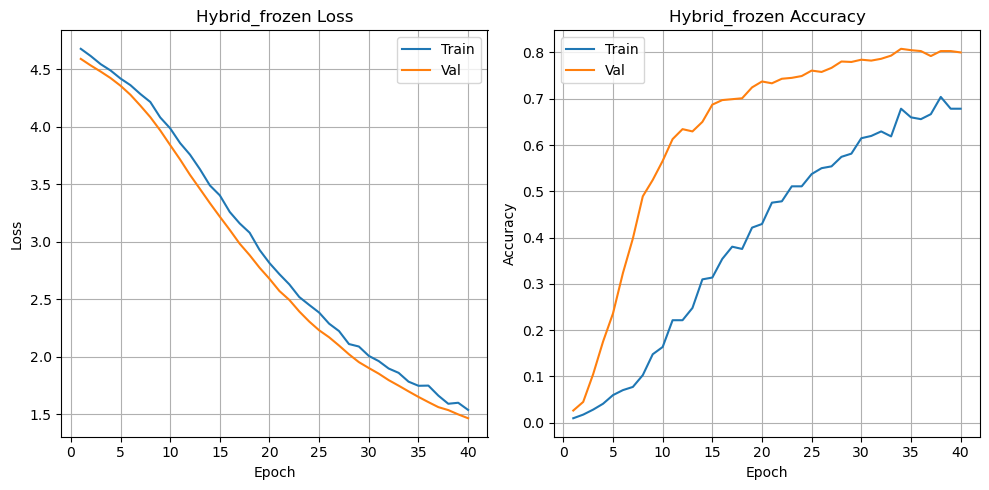

In [12]:
plot_hybrid_history("Hybrid_frozen")

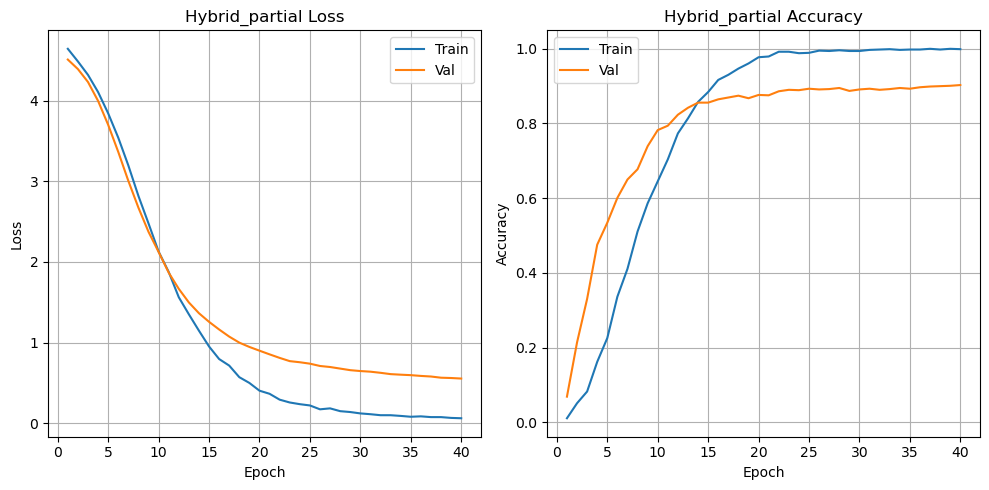

In [31]:
plot_hybrid_history("Hybrid_partial")

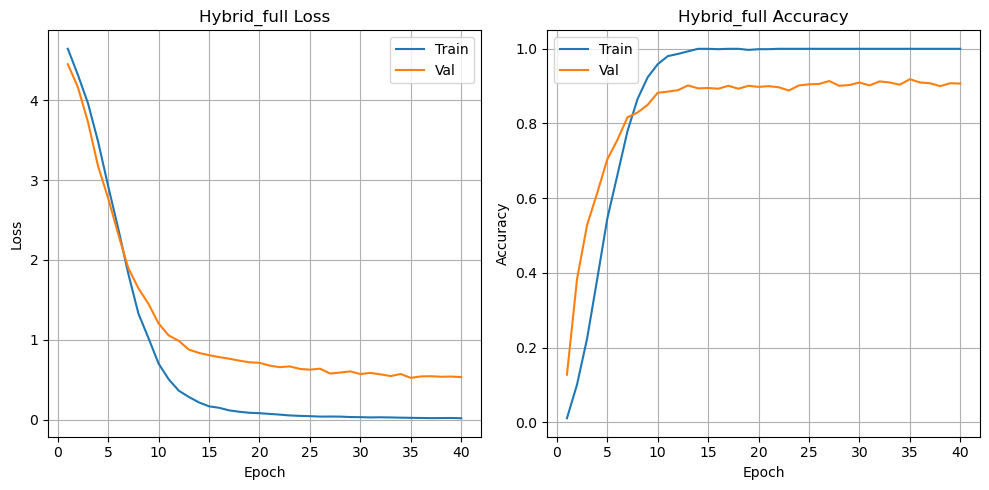

In [13]:
plot_hybrid_history("Hybrid_full")

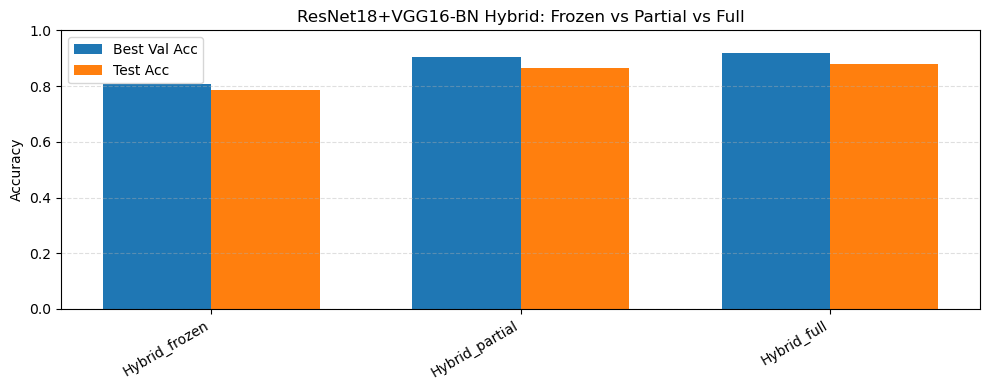

In [14]:
plot_hybrid_summary_bar(hybrid_summary)